# Hierarchical Clustering — Tutorial

This notebook will cover math, implementation, and visualization for hierarchical clustering.


## Math Background

We consider a dataset $X = \{\mathbf{x}_1,\ldots,\mathbf{x}_n\}$ with $\mathbf{x}_i \in \mathbb{R}^d$ and a pairwise distance $d(\mathbf{x}_i,\mathbf{x}_j)$. Let $D \in \mathbb{R}^{n \times n}$ be the distance matrix with $D_{ij} = d(\mathbf{x}_i,\mathbf{x}_j)$.

**Common metrics**
- Euclidean: $$ d_2(\mathbf{a}, \mathbf{b}) = \sqrt{\sum_{k=1}^{d} (a_k - b_k)^2}. $$
- Manhattan: $$ d_1(\mathbf{a}, \mathbf{b}) = \sum_{k=1}^{d} \lvert a_k - b_k \rvert. $$
- Cosine: $$ d_{\text{cos}}(\mathbf{a}, \mathbf{b}) = 1 - \frac{\mathbf{a}^\top \mathbf{b}}{\|\mathbf{a}\|\;\|\mathbf{b}\|}. $$

### Agglomerative clustering
Start with $n$ singleton clusters and iteratively merge the two closest clusters until one remains.



### Linkage criteria

Let $A$ and $B$ be clusters. Define their inter-cluster dissimilarity $d(A,B)$ as one of:

- Single linkage: $$ d_{\text{single}}(A,B) = \min_{\mathbf{x}\in A,\,\mathbf{y}\in B} d(\mathbf{x}, \mathbf{y}). $$
- Complete linkage: $$ d_{\text{complete}}(A,B) = \max_{\mathbf{x}\in A,\,\mathbf{y}\in B} d(\mathbf{x}, \mathbf{y}). $$
- Average linkage (UPGMA): $$ d_{\text{average}}(A,B) = \frac{1}{|A|\,|B|} \sum_{\mathbf{x}\in A} \sum_{\mathbf{y}\in B} d(\mathbf{x},\mathbf{y}). $$
- Ward’s method: $$ \Delta(A,B) = \frac{|A|\,|B|}{|A| + |B|}\,\|\boldsymbol{\mu}_A - \boldsymbol{\mu}_B\|_2^2. $$



### Lance–Williams recurrence

When merging $A$ and $B$ into $C = A \cup B$, distances to another cluster $K$ can be updated with:
$$
d(C, K) = \alpha_A d(A,K) + \alpha_B d(B,K) + \beta d(A,B) + \gamma \lvert d(A,K) - d(B,K) \rvert.
$$
For average linkage: $\alpha_A=\frac{|A|}{|A|+|B|}, \alpha_B=\frac{|B|}{|A|+|B|}, \beta=0, \gamma=0$.



### Stopping, dendrograms, and complexity

The algorithm produces a **dendrogram** that records merge heights. **Cut** the dendrogram by a chosen level (or set $k$).

- Visual inspection of gaps
- Silhouette score
- Domain knowledge

Complexity: naïve $O(n^3)$ time and $O(n^2)$ memory; specialized methods can be $O(n^2)$.


In [1]:

# === Setup: imports ===
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import pdist

print("Libraries imported.")


Libraries imported.



## Synthetic datasets

We will generate two datasets:
1. **Blobs** (roughly spherical) — good for Ward/complete.
2. **Two Moons** (non-convex) — single/average can better respect shape.


In [2]:

# Create synthetic datasets
X_blobs, y_blobs = make_blobs(n_samples=600, centers=4, cluster_std=[1.0, 1.2, 0.9, 1.1], random_state=42)
X_moons, y_moons = make_moons(n_samples=600, noise=0.08, random_state=42)

# Standardize
Xb = StandardScaler().fit_transform(X_blobs)
Xm = StandardScaler().fit_transform(X_moons)

print("Datasets prepared:", Xb.shape, Xm.shape)


Datasets prepared: (600, 2) (600, 2)



## Dendrograms with `scipy`

We first compute pairwise distances with `pdist`, then hierarchical linkage and visualize a **dendrogram**.

> Note: Each plot is separate as a single figure (no subplots used here).


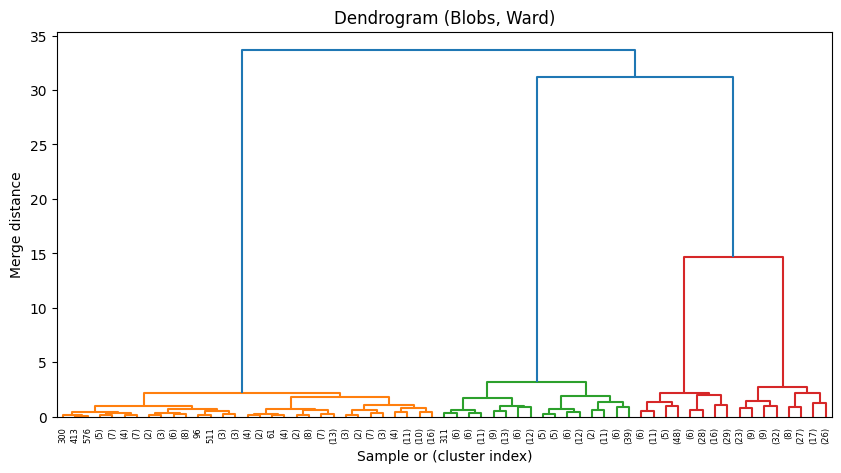

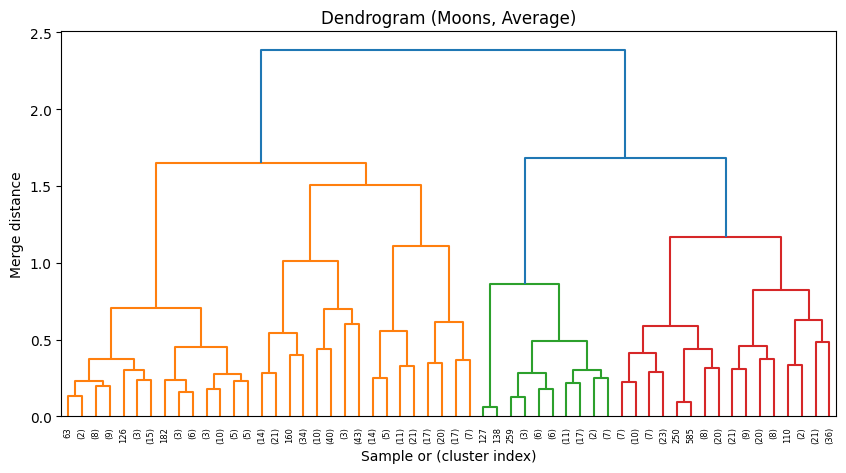

In [3]:

# Dendrogram for Blobs using Ward's method
Z_blobs_ward = linkage(Xb, method="ward")
plt.figure(figsize=(10, 5))
dendrogram(Z_blobs_ward, truncate_mode="level", p=5)
plt.title("Dendrogram (Blobs, Ward)")
plt.xlabel("Sample or (cluster index)")
plt.ylabel("Merge distance")
plt.show()

# Dendrogram for Moons using Average linkage
Z_moons_avg = linkage(Xm, method="average", metric="euclidean")
plt.figure(figsize=(10, 5))
dendrogram(Z_moons_avg, truncate_mode="level", p=5)
plt.title("Dendrogram (Moons, Average)")
plt.xlabel("Sample or (cluster index)")
plt.ylabel("Merge distance")
plt.show()



### Cophenetic correlation

The **cophenetic correlation coefficient** compares original pairwise distances with cophenetic distances implied by the dendrogram. Higher is better.

$$
\\text{coph} = \\mathrm{corr}\\big(\\mathrm{vec}(D),\\; \\mathrm{vec}(D_{\\text{coph}})\\big).
$$


In [4]:

# Cophenetic correlation for both linkages
c_blobs, _ = cophenet(Z_blobs_ward, pdist(Xb))
c_moons, _ = cophenet(Z_moons_avg, pdist(Xm))
print("Cophenetic correlation (Blobs, Ward):", round(float(c_blobs), 4))
print("Cophenetic correlation (Moons, Average):", round(float(c_moons), 4))


Cophenetic correlation (Blobs, Ward): 0.936
Cophenetic correlation (Moons, Average): 0.7524



## Cutting the dendrogram to get $k$ clusters
We can either **cut by distance** or **choose $k$** directly. Below, we choose $k$ and visualize the resulting cluster labels.


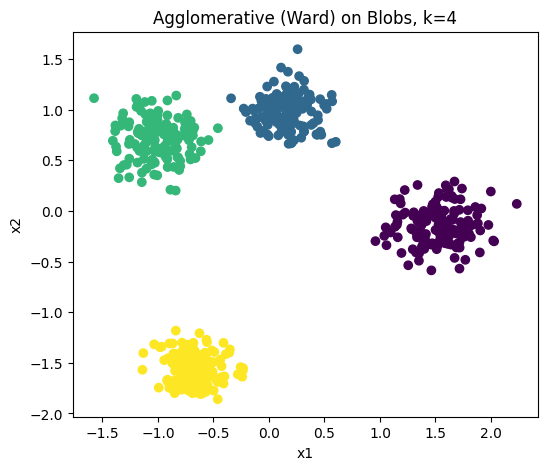

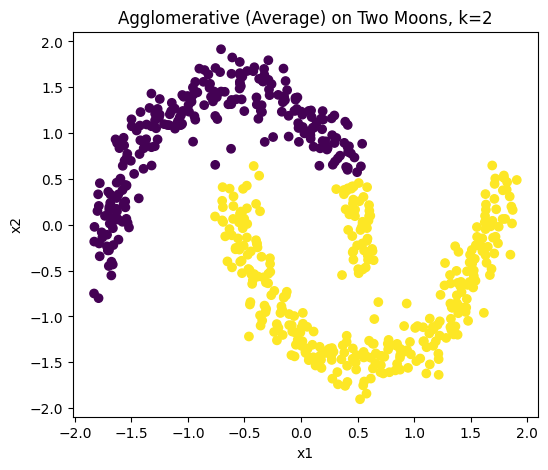

In [5]:

# Choose k clusters
k_blobs = 4
k_moons = 2

# Using scikit-learn's AgglomerativeClustering for labels
agg_blobs = AgglomerativeClustering(n_clusters=k_blobs, linkage="ward")
labels_blobs = agg_blobs.fit_predict(Xb)

agg_moons = AgglomerativeClustering(n_clusters=k_moons, linkage="average")
labels_moons = agg_moons.fit_predict(Xm)

plt.figure(figsize=(6, 5))
plt.scatter(Xb[:, 0], Xb[:, 1], c=labels_blobs)
plt.title("Agglomerative (Ward) on Blobs, k=4")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(Xm[:, 0], Xm[:, 1], c=labels_moons)
plt.title("Agglomerative (Average) on Two Moons, k=2")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()



## Silhouette analysis

The **silhouette score** for a sample is:
$$
s = \frac{b - a}{\max(a,b)},
$$
where $a$ is the mean intra-cluster distance and $b$ is the mean nearest-cluster distance. The overall score is the mean $s$ over all samples, in $[-1,1]$; higher is better.


k values (blobs): [2, 3, 4, 5, 6, 7]
silhouette (blobs): [0.556 0.737 0.783 0.669 0.565 0.556]
k values (moons): [2, 3, 4, 5, 6, 7]
silhouette (moons): [0.46  0.418 0.368 0.423 0.443 0.47 ]


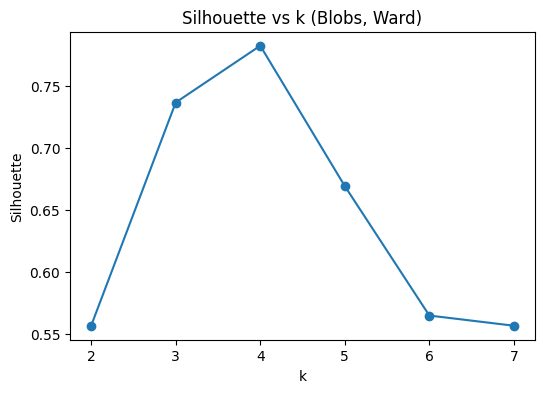

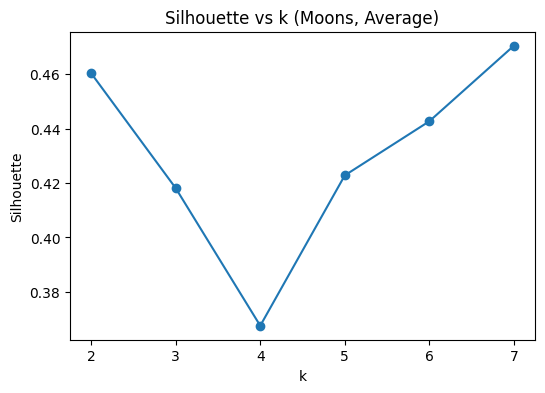

In [6]:

import numpy as np

def sweep_silhouette(X, link, ks):
    scores = []
    for k in ks:
        model = AgglomerativeClustering(n_clusters=k, linkage=link)
        labels = model.fit_predict(X)
        if k > 1:
            score = silhouette_score(X, labels, metric="euclidean")
        else:
            score = np.nan
        scores.append(score)
    return np.array(scores, dtype=float)

ks_blobs = list(range(2, 8))
ks_moons = list(range(2, 8))

scores_blobs = sweep_silhouette(Xb, "ward", ks_blobs)
scores_moons = sweep_silhouette(Xm, "average", ks_moons)

print("k values (blobs):", ks_blobs)
print("silhouette (blobs):", np.round(scores_blobs, 3))
print("k values (moons):", ks_moons)
print("silhouette (moons):", np.round(scores_moons, 3))

plt.figure(figsize=(6, 4))
plt.plot(ks_blobs, scores_blobs, marker="o")
plt.title("Silhouette vs k (Blobs, Ward)")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(ks_moons, scores_moons, marker="o")
plt.title("Silhouette vs k (Moons, Average)")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()



## From-scratch agglomerative clustering (educational)

Below is a simple, readable implementation for **average linkage** using a dense distance matrix. It is $O(n^3)$ and intended only for small $n$ (e.g., $n \le 80$). It returns the merge history (similar to SciPy's `linkage` output) and allows you to create a dendrogram.

We use the average-linkage Lance–Williams update:
$$
d(A\cup B, K) = \frac{|A|}{|A|+|B|} d(A,K) + \frac{|B|}{|A|+|B|} d(B,K).
$$


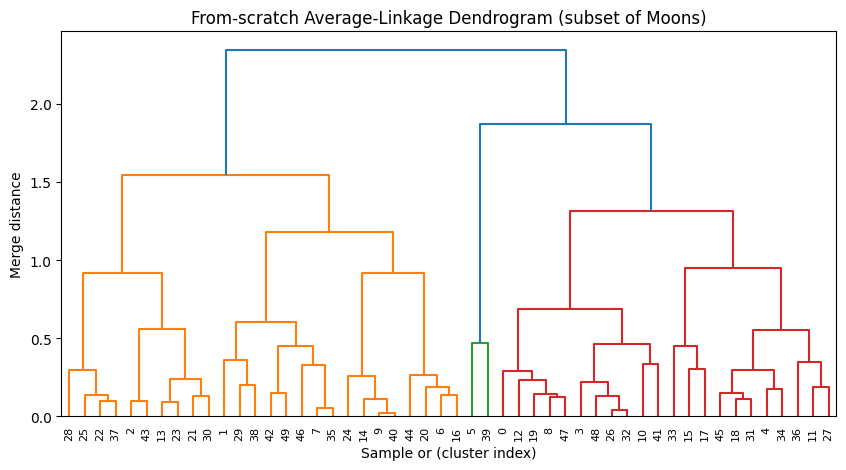

In [7]:

from scipy.cluster.hierarchy import dendrogram

def hac_average_linkage(X):
    '''
    Hierarchical Agglomerative Clustering (Average Linkage)
    Returns: Z (n-1, 4) linkage-like array:
      [idx_A, idx_B, merge_distance, size_of_new_cluster]
    Cluster indices: 0..n-1 are initial points; new clusters get indices n, n+1, ...
    '''
    X = np.asarray(X, dtype=float)
    n = X.shape[0]
    D = pdist(X, metric="euclidean")

    def key(i, j):
        return (i, j) if i < j else (j, i)

    dist = {}
    idx = 0
    for i in range(n):
        for j in range(i+1, n):
            dist[(i, j)] = D[idx]
            idx += 1

    active = {i: 1 for i in range(n)}  # size of each active cluster
    Z = []
    next_label = n

    while len(active) > 1:
        labels = sorted(active.keys())
        best = None
        pair = None
        for a_i in range(len(labels)):
            for b_i in range(a_i+1, len(labels)):
                a, b = labels[a_i], labels[b_i]
                d_ab = dist.get(key(a, b))
                if best is None or d_ab < best:
                    best = d_ab
                    pair = (a, b)

        a, b = pair
        size_a, size_b = active[a], active[b]
        new_label = next_label
        next_label += 1

        # Record merge
        Z.append([a, b, float(best), size_a + size_b])

        # Update distances to new cluster
        for k in list(active.keys()):
            if k in (a, b):
                continue
            d_ak = dist.get(key(a, k))
            d_bk = dist.get(key(b, k))
            new_d = (size_a * d_ak + size_b * d_bk) / (size_a + size_b)
            dist[key(new_label, k)] = new_d

        # Clean old keys
        for k in list(active.keys()):
            if k not in (a, b):
                dist.pop(key(a, k), None)
                dist.pop(key(b, k), None)
        dist.pop(key(a, b), None)

        # Update active
        del active[a]
        del active[b]
        active[new_label] = size_a + size_b

    Z = np.array(Z, dtype=float)
    return Z

# Demo on a subset of the moons data
Xm_small = Xm[:50]
Z_small = hac_average_linkage(Xm_small)

plt.figure(figsize=(10, 5))
dendrogram(Z_small)
plt.title("From-scratch Average-Linkage Dendrogram (subset of Moons)")
plt.xlabel("Sample or (cluster index)")
plt.ylabel("Merge distance")
plt.show()



## Practical tips

- **Scale your features** (e.g., `StandardScaler`) if units differ; Ward's method assumes Euclidean geometry.
- For **non-convex shapes**, try single/average linkage (but beware noise sensitivity).
- For **large $n$**, dendrograms become cluttered—use truncation or sample your data.
- Consider **cosine distance** for high-dimensional direction-dominant data.
- Use **cophenetic correlation** and **silhouette** to cross-check structure quality.


In [8]:

# Versions
import sys, sklearn, scipy, numpy as np
print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("SciPy:", scipy.__version__)
print("scikit-learn:", sklearn.__version__)


Python: 3.12.12
NumPy: 2.0.2
SciPy: 1.16.2
scikit-learn: 1.6.1
